# Visualizing Text Data

What makes text data so difficult to visualize?


The unstructured nature of text data makes it much more difficult to analyze.  Because it often takes a lot of preprocessing to visualize text data, we'll focus on talking through these examples rather than writing code.

In this lecture, we're going to focus on analyzing reviews of a few fancy European restaurants.  What do people like?  What are they complaing about?  How can we figure that out?

## What are some relationships we might try to visualize using this data?

### We can use a word clouds:

Positive Review Titles


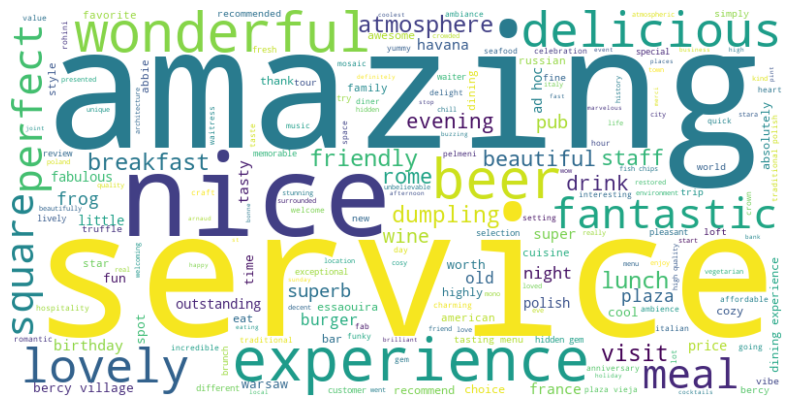

Negative Review Titles


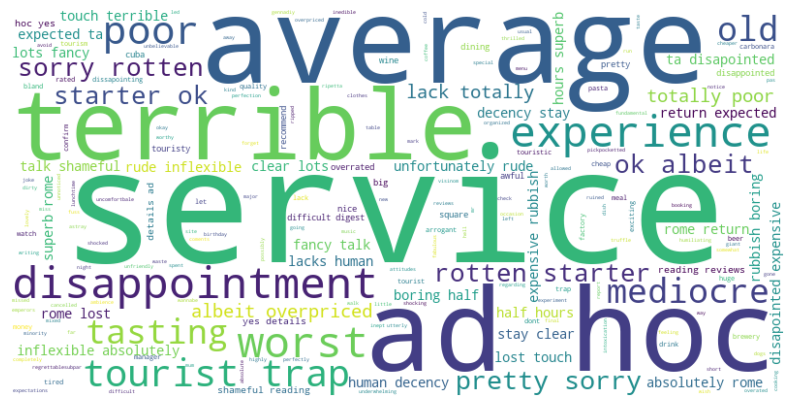

In [6]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
import pandas as pd
import string
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS as sklearn_stop_words

df = pd.read_csv('assets/European Restaurant Reviews.csv')

# Define additional stopwords to remove
additional_stopwords = {'food', 'restaurant', 'good', 'best', 'great', 'bad', 'disappointing', 'dinner', 'place', 'excellent'}

# Separate positive and negative reviews
positive_reviews = ' '.join(df[df['Sentiment'] == 'Positive']['Review Title'].astype(str))
negative_reviews = ' '.join(df[df['Sentiment'] == 'Negative']['Review Title'].astype(str))

# Tokenize the words
postive_words = positive_reviews.lower().split()
    
# Remove punctuation and stopwords (including additional stopwords)
postive_words = [word.strip(string.punctuation) for word in postive_words if word.isalnum() and word not in sklearn_stop_words and word not in additional_stopwords]
    
# Generate the word cloud
print('Positive Review Titles')
wordcloud = WordCloud(width=800, height=400, background_color ='white').generate(' '.join(postive_words))
plt.figure(figsize=(10, 7)) 
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

#Negative reviews
negative_words = negative_reviews.lower().split()
    
# Remove punctuation and stopwords (including additional stopwords)
negative_words = [word.strip(string.punctuation) for word in negative_words if word.isalnum() and word not in sklearn_stop_words and word not in additional_stopwords]
    
# Generate the word cloud
print('Negative Review Titles')
wordcloud = WordCloud(width=800, height=400, background_color ='white').generate(' '.join(negative_words))
plt.figure(figsize=(10, 7)) 
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


What are some positive aspects of word clouds?  What are some negatives?

### We can look at word frequencies:

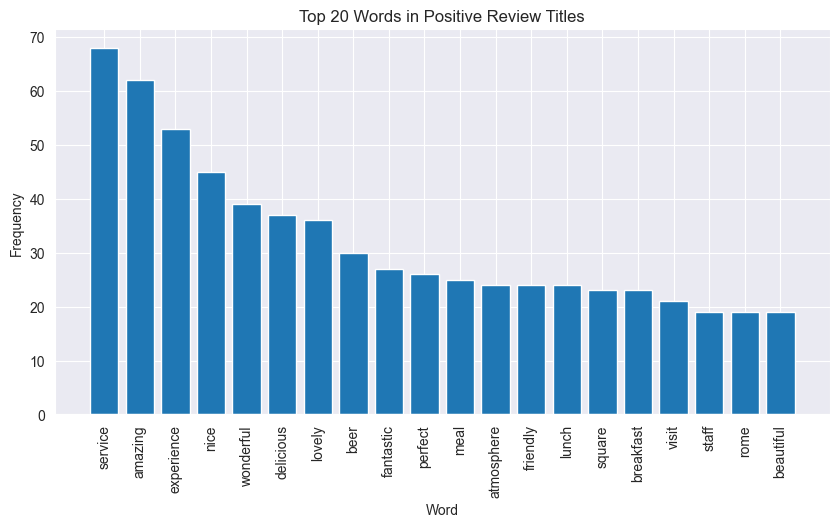

In [7]:
positive_word_freq = Counter(postive_words)
positive_common_words = positive_word_freq.most_common(20)
    
# Convert to DataFrame for plotting
positive_freq_df = pd.DataFrame(positive_common_words, columns=['Word', 'Frequency'])
    
fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(positive_freq_df['Word'], positive_freq_df['Frequency'])
ax.set_title(f'Top 20 Words in Positive Review Titles')
ax.set_xlabel('Word')
ax.set_ylabel('Frequency')
plt.xticks(rotation=90)
plt.show()

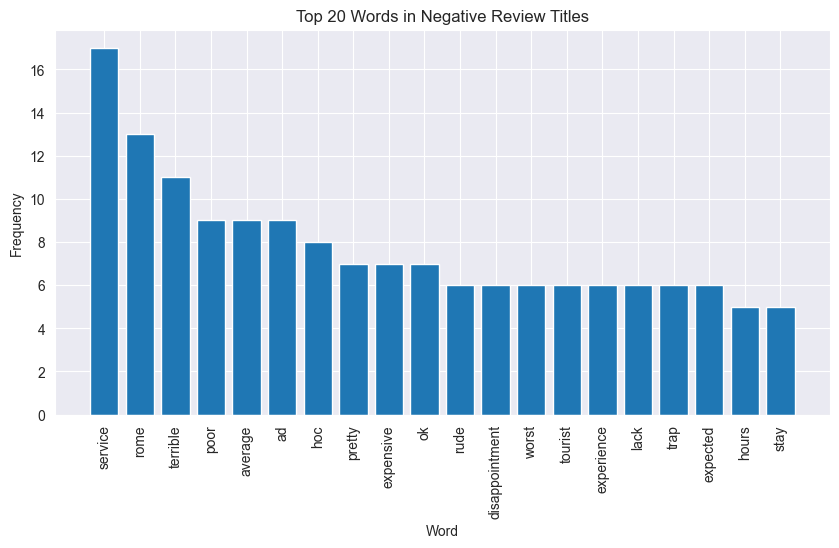

In [8]:
negative_word_freq = Counter(negative_words)
negative_common_words = negative_word_freq.most_common(20)
    
# Convert to DataFrame for plotting
negative_freq_df = pd.DataFrame(negative_common_words, columns=['Word', 'Frequency'])
    
fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(negative_freq_df['Word'], negative_freq_df['Frequency'])
ax.set_title(f'Top 20 Words in Negative Review Titles')
ax.set_xlabel('Word')
ax.set_ylabel('Frequency')
plt.xticks(rotation=90)
plt.show()

## Sentiment

Another way to look at the data is to see how different words factor into the overall sentiment of a review.  There are different ways to do this, but one way is by using the textblob library (Python has tons of NLP libraries) to compute the sentiment of each review.  Sentiment can be positive (a positive value), negative (a negative value) or neutral (a value at or near 0).  

Interestingly, the sentiment calculated by textblob doesn't align perfectly (though it does generally match up) with the positive/negative label given in the data.  

Let's look at the sentiment vs subjectivity color coded by the sentiment label in the dataset.


In [9]:
#%pip install textblob
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
from textblob import TextBlob
import plotly.express as px

# Sentiment calculations
df['calc_sentiment'] = df['Review Title'].apply(lambda x: TextBlob(x).sentiment.polarity)
df['subjectivity'] = df['Review Title'].apply(lambda x: TextBlob(x).sentiment.subjectivity)
df['abs_sentiment'] = df['calc_sentiment'].abs()

# Optional: Make sentiment a category to suppress warning
df['Sentiment'] = df['Sentiment'].astype(str)

# Plot
fig = px.scatter(
    df, 
    x='calc_sentiment', 
    y='subjectivity', 
    hover_data=['Review Title'],
    color='Sentiment',
    size='abs_sentiment',
    size_max=15,
    title='Sentiment Polarity vs Subjectivity',
    hover_name='Restaurant Name',
    labels={'sentiment': 'Sentiment Polarity', 'subjectivity': 'Subjectivity'}
)

fig.update_layout(xaxis_title='Sentiment', height=500)
fig.show()



Now lets color code by restaruant.


In [10]:
fig = px.scatter(df, x='calc_sentiment', y='subjectivity', 
                 hover_data=['Review Title'],
                 color='Restaurant Name',
                 size='abs_sentiment',
                 size_max = 15,
                 title='Sentiment Polarity vs Subjectivity',
                 hover_name = 'Restaurant Name',
                 labels={'sentiment': 'Sentiment Polarity', 'subjectivity': 'Subjectivity'})

fig.update_layout(xaxis_title = 'Sentiment', height=500)
fig.show()

Let's look at the range of sentiment associated with each word.

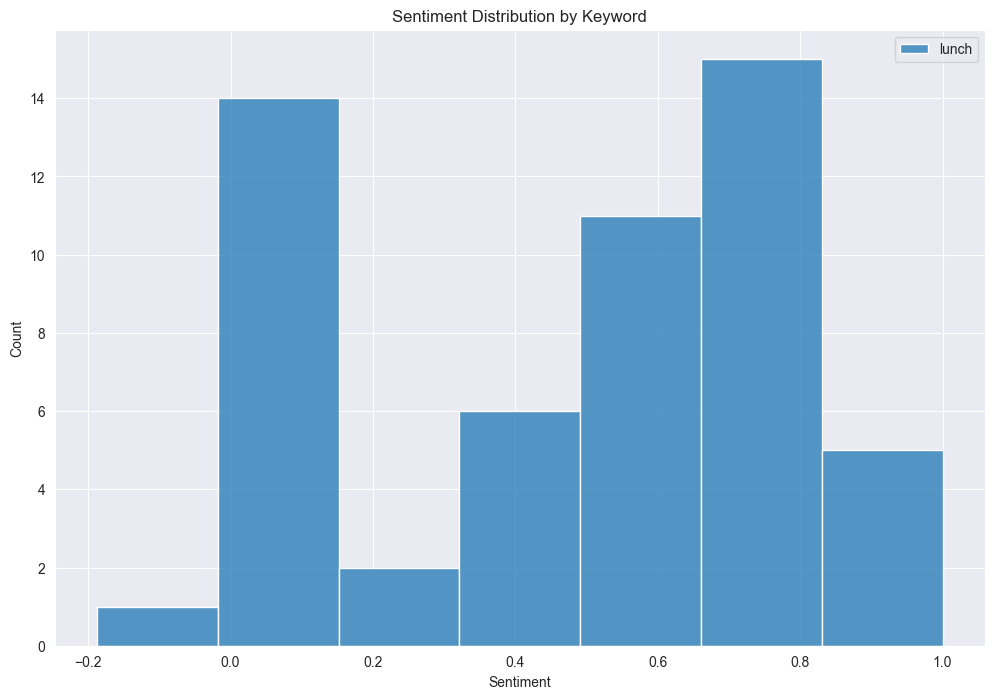

In [11]:
import seaborn as sns

keywords = ['lunch']#["wait", "service", "expensive"] #["disgusting", "delicious", "overpriced"]#, ]

# Filter reviews based on the presence of keywords and compute sentiment for each keyword
sentiments = {}
for keyword in keywords:
    sentiments[keyword] = df[df['Review'].str.contains(keyword, case=False, na=False)]['calc_sentiment']

# Plot
plt.figure(figsize=(12, 8))
for keyword, sentiment in sentiments.items():
    sns.histplot(sentiment, label=keyword)
    
plt.title('Sentiment Distribution by Keyword')
plt.xlabel('Sentiment')
plt.legend()

### Review Metadata

In [11]:
import numpy as np
texts = {}
blobs = {name: TextBlob(text) for name, text in texts.items() }
vocab = set(w for blob in blobs.values() for w in blob.word_counts())

def wc_vector(blob, vocab):
	wc = blob.word_counts
	return np.array( [wc.get(w, 0) for w in vocab])

vectors = {name: wc_vector(blob, vocab) for name, blob in blobs.items()}

# cosine similarities
def cosine(a, b):
	dot = np.dot(a,b) # not normalized.
	na, nb = np.linalg.norm(a), np.linalg.norm(b)
	return dot / (na * nb) in na and nb else 0.0

	base = "Federalist 49 (disputed)"

	for other in ["Federalist 10 (Madison)", "Federalist 78 (Hamilton)"]:
		similarity = cosine(vectors[base], vectors[others])

